# Day 57：经典时序模型（1）——差分、ACF/PACF 与 AR/MA/ARMA


## 学习要点
1. **平稳性**为什么重要（很多经典模型的前提）。
2. **差分**如何消除趋势（让序列更接近平稳）。
3. **季节性差分**如何消除周期波动。
4. **ACF / PACF**如何辅助判断：AR(p)、MA(q)、ARMA(p,q)。

## 本节约定
- 下面的例子主要用**模拟数据**，目的是把概念“看见”。
- ACF/PACF 的经验规律适用于**已经平稳**的序列；如果原序列不平稳，请先差分。


## 先回顾：我们要检验什么？

做经典时间序列建模（如 ARIMA）前，常见的“体检项目”包括：

1. **自相关性（ACF/PACF）**：序列是否存在滞后相关（是否“有记忆”）。
2. **平稳性（ADF）**：均值/方差等统计特性是否随时间变化。
3. **季节性**：是否存在固定周期（如月度数据的 12 个月周期）。

接下来我们主要处理两类“常见问题”：
- **趋势导致的非平稳** → 用（普通）差分处理。
- **季节性导致的周期结构** → 用季节性差分处理。

而“自相关性”并不是要消除的毛病，反而是后续选择 AR/MA/ARMA 的重要线索。


# 一、让序列更平稳：差分

## 1.1 为什么要平稳？
很多经典时序模型假设序列的统计特性相对稳定（均值、方差、协方差不随时间漂移）。
如果序列存在明显趋势（均值在变）或波动强度在变（方差在变），模型会更难“抓住规律”。

## 1.2 普通差分（处理趋势）
差分的思想：把“水平”变化转为“变化速度”。

- **一阶差分**：
$$\Delta y_t = y_t - y_{t-1}$$
- **二阶差分**（对一阶差分再差分）：
$$\Delta^2 y_t = \Delta y_t - \Delta y_{t-1}$$

实践中通常先尝试一阶差分；差分次数越高，越容易把结构“过度差分”掉（信息被抹平）。


In [1]:
# 通用依赖与工具函数
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

# 尽量避免中文乱码：优先使用 SimHei，没有的话会回退到其他字体
plt.rcParams["font.sans-serif"] = ["SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False


def adf_test(series: pd.Series, name: str = "序列"):
    """ADF 单位根检验：p-value 越小，越倾向于拒绝“存在单位根（非平稳）”的原假设。"""
    series = pd.Series(series).dropna()
    stat, p_value, _, _, critical_values, _ = adfuller(series, autolag="AIC")
    print(f"[{name}] ADF Statistic: {stat:.4f}")
    print(f"[{name}] p-value      : {p_value:.6f}")
    print(f"[{name}] Critical    : { {k: round(v, 4) for k, v in critical_values.items()} }")


### 1.3 用“随机游走 + 趋势”构造一个典型的非平稳序列

随机游走（Random Walk）是时间序列里非常经典的“非平稳”例子：
- 它会随时间漂移，没有稳定的均值；
- 叠加一个线性趋势后，非平稳性会更明显。

下面我们生成一段数据，并用 ADF 检验 + 一阶差分来观察“治疗前后”的变化。


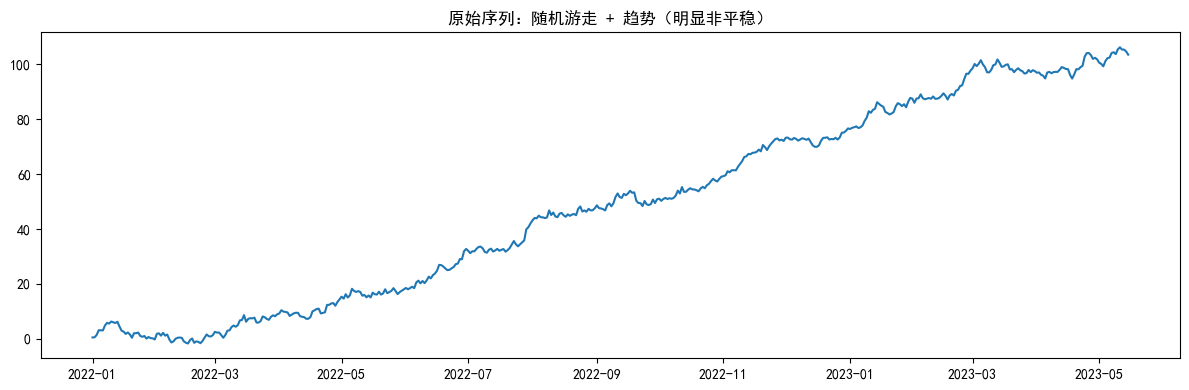

[原始序列] ADF Statistic: 0.1358
[原始序列] p-value      : 0.968421
[原始序列] Critical    : {'1%': np.float64(-3.4435), '5%': np.float64(-2.8673), '10%': np.float64(-2.5699)}


In [2]:
# 1) 生成非平稳数据：随机游走 + 线性趋势
np.random.seed(42)

n = 500
random_walk = np.random.randn(n).cumsum()  # 累积和 -> 随机游走
trend = np.linspace(0, 100, n)            # 线性趋势

data = pd.Series(random_walk + trend)
data.index = pd.date_range(start="2022-01-01", periods=n, freq="D")

plt.figure(figsize=(12, 4))
plt.plot(data)
plt.title("原始序列：随机游走 + 趋势（明显非平稳）")
plt.tight_layout()
plt.show()

adf_test(data, name="原始序列")


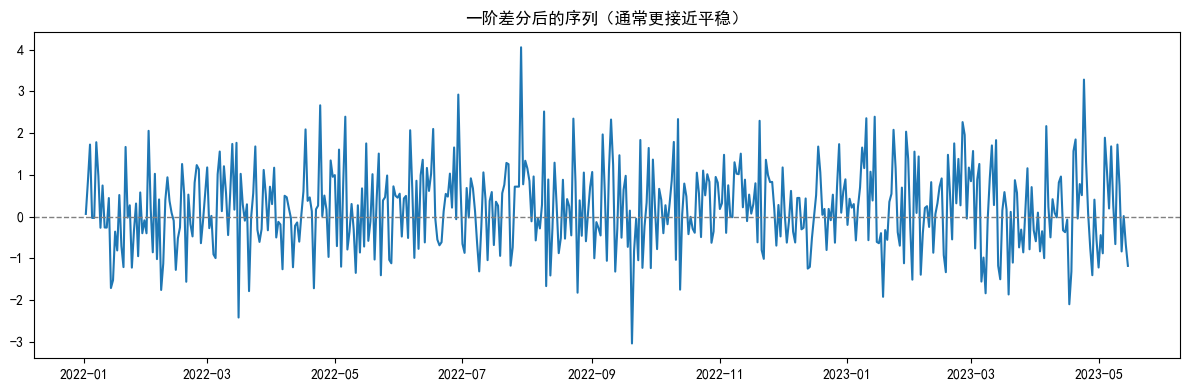

[一阶差分后] ADF Statistic: -22.3130
[一阶差分后] p-value      : 0.000000
[一阶差分后] Critical    : {'1%': np.float64(-3.4435), '5%': np.float64(-2.8674), '10%': np.float64(-2.5699)}


In [3]:
# 2) 一阶差分：尝试消除趋势
data_diff_1 = data.diff().dropna()

plt.figure(figsize=(12, 4))
plt.plot(data_diff_1)
plt.axhline(0, color="gray", linewidth=1, linestyle="--")
plt.title("一阶差分后的序列（通常更接近平稳）")
plt.tight_layout()
plt.show()

adf_test(data_diff_1, name="一阶差分后")


# 二、处理季节性：季节性差分

很多序列（销量、客流、气温）会在固定周期内重复波动，这就是季节性。

## 2.1 季节性差分（Seasonal Differencing）
思想与普通差分相同，只是“减去的不是上一期”，而是“减去上一个周期的同位置”。

$$\Delta_s y_t = y_t - y_{t-s}$$

- 月度数据的年度季节：`s = 12`
- 季度数据的年度季节：`s = 4`

如果序列同时存在**趋势 + 季节性**，常见做法是：
- 先做季节性差分（去周期），再对结果做一阶差分（去趋势）。


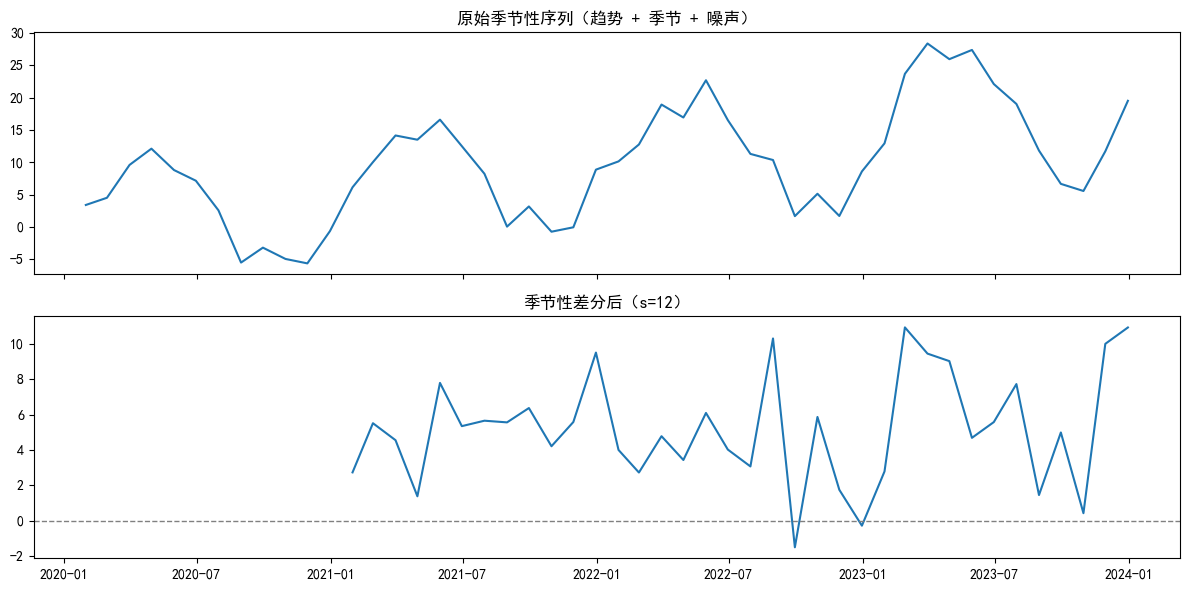

[原始季节性序列] ADF Statistic: 0.7819
[原始季节性序列] p-value      : 0.991338
[原始季节性序列] Critical    : {'1%': np.float64(-3.6155), '5%': np.float64(-2.9413), '10%': np.float64(-2.6092)}
[季节性差分后（s=12）] ADF Statistic: -5.5909
[季节性差分后（s=12）] p-value      : 0.000001
[季节性差分后（s=12）] Critical    : {'1%': np.float64(-3.6327), '5%': np.float64(-2.9485), '10%': np.float64(-2.613)}


In [4]:
# 生成一段“趋势 + 季节性 + 噪声”的月度序列，并做季节性差分
np.random.seed(7)

# 4 年月度数据（48个点），周期为 12
time_index = pd.date_range(start="2020-01-01", periods=48, freq="M")

seasonal = 10 * np.sin(np.arange(48) * (2 * np.pi / 12))  # 振幅10，周期12
trend = np.linspace(0, 20, 48)
noise = np.random.randn(48) * 2

seasonal_data = pd.Series(seasonal + trend + noise, index=time_index)
seasonal_diff_12 = seasonal_data.diff(periods=12).dropna()

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(seasonal_data)
axes[0].set_title("原始季节性序列（趋势 + 季节 + 噪声）")

axes[1].plot(seasonal_diff_12)
axes[1].axhline(0, color="gray", linewidth=1, linestyle="--")
axes[1].set_title("季节性差分后（s=12）")

plt.tight_layout()
plt.show()

adf_test(seasonal_data, name="原始季节性序列")
adf_test(seasonal_diff_12, name="季节性差分后（s=12）")


# 三、模型选择：AR / MA / ARMA 与 ACF/PACF

现在假设我们已经拿到了**平稳序列**（原序列平稳，或通过差分变得平稳）。

## 3.1 ACF 与 PACF：分别在看什么？
- **ACF（自相关）**：$y_t$ 与 $y_{t-k}$ 的相关性（包含间接影响）。
- **PACF（偏自相关）**：控制了中间滞后项后，$y_t$ 与 $y_{t-k}$ 的“直接相关”。

## 3.2 “截尾”与“拖尾”（经验规律）
| 模型 | ACF 特征 | PACF 特征 |
|---|---|---|
| AR(p) | 拖尾 | 在 p 阶后截尾 |
| MA(q) | 在 q 阶后截尾 | 拖尾 |
| ARMA(p,q) | 拖尾 | 拖尾 |

注意：这是非常常用的入门规律，但真实业务数据里常需要结合 AIC/BIC、残差白噪声检验等一起判断。


## 3.3 AR(p)：自回归（“惯性/记忆”）

AR(p) 的直观解释：当前值由过去 p 期的值线性决定（再加上随机扰动）。

$$y_t = \phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \varepsilon_t$$

下面模拟一个 AR(2) 序列，并用 ACF/PACF 验证“PACF 在 2 阶后截尾”的现象。


--- 案例一：AR(2) 模型 ---


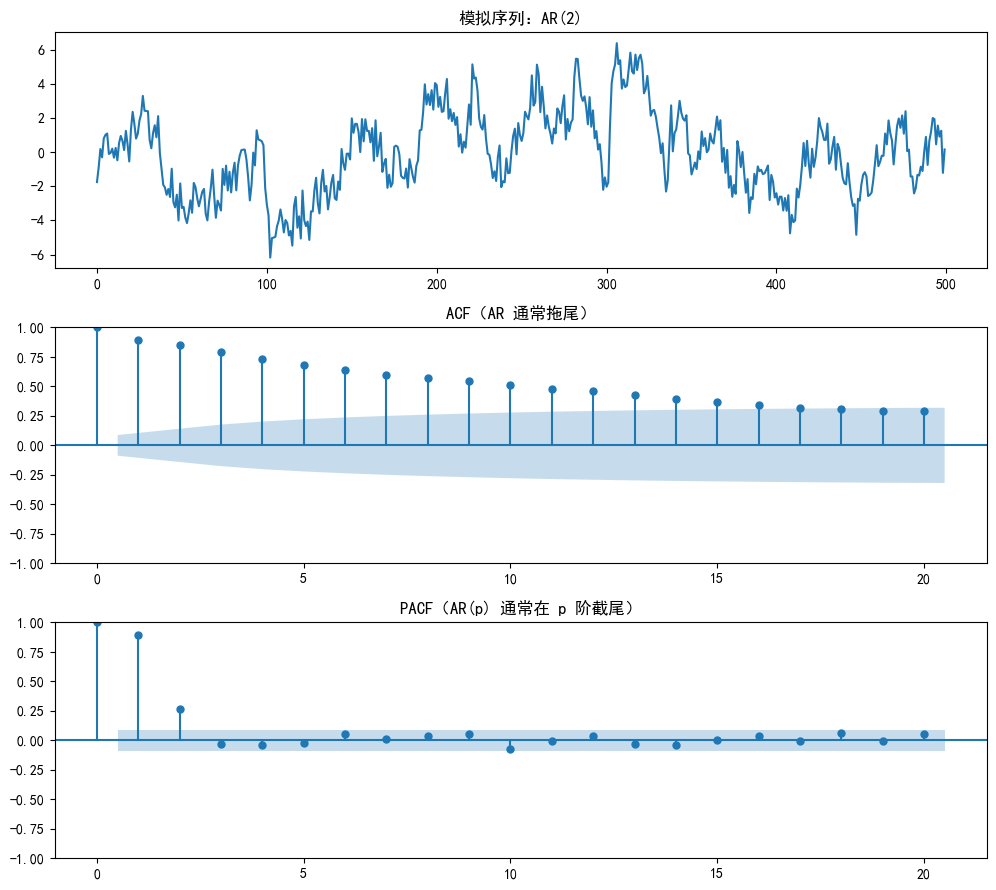

In [5]:
# --- 案例一：AR(2) ---
print("--- 案例一：AR(2) 模型 ---")

# AR(2)：y_t = 0.7 y_{t-1} + 0.2 y_{t-2} + ε_t
ar_params = np.array([0.7, 0.2])
ma_params = np.array([])

# from_coeffs 的 AR 系数会按统计学常见写法自动处理符号
ar_process = ArmaProcess.from_coeffs(arcoefs=ar_params, macoefs=ma_params)

np.random.seed(100)
ar_data = ar_process.generate_sample(nsample=500)

fig, axes = plt.subplots(3, 1, figsize=(10, 9))
axes[0].plot(ar_data)
axes[0].set_title("模拟序列：AR(2)")

plot_acf(ar_data, ax=axes[1], lags=20, title="ACF（AR 通常拖尾）")
plot_pacf(ar_data, ax=axes[2], lags=20, title="PACF（AR(p) 通常在 p 阶截尾）")

plt.tight_layout()
plt.show()


In [6]:
# 使用 ARIMA(p,d,q) 形式拟合：AR(2) 等价于 ARIMA(2,0,0)
model_ar = ARIMA(ar_data, order=(2, 0, 0)).fit()
print(model_ar.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -724.007
Date:                Fri, 09 Jan 2026   AIC                           1456.014
Time:                        15:58:24   BIC                           1472.873
Sample:                             0   HQIC                          1462.629
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0971      0.578     -0.168      0.867      -1.231       1.036
ar.L1          0.6557      0.042     15.552      0.000       0.573       0.738
ar.L2          0.2646      0.043      6.096      0.0

## 3.4 MA(q)：移动平均（“短期冲击”）

MA(q) 的直观解释：当前值由当前与过去 q 期的**随机冲击（误差项）**叠加形成。

$$y_t = \varepsilon_t + \theta_1 \varepsilon_{t-1} + \cdots + \theta_q \varepsilon_{t-q}$$

它很适合描述“突发冲击会影响一小段时间然后消失”的现象，例如：
- 生产线短暂故障、突发促销、短期测量误差。

MA(q) 的典型经验规律：**ACF 在 q 阶后截尾**，而 PACF 往往拖尾。


--- 案例二：MA(2) 模型 ---


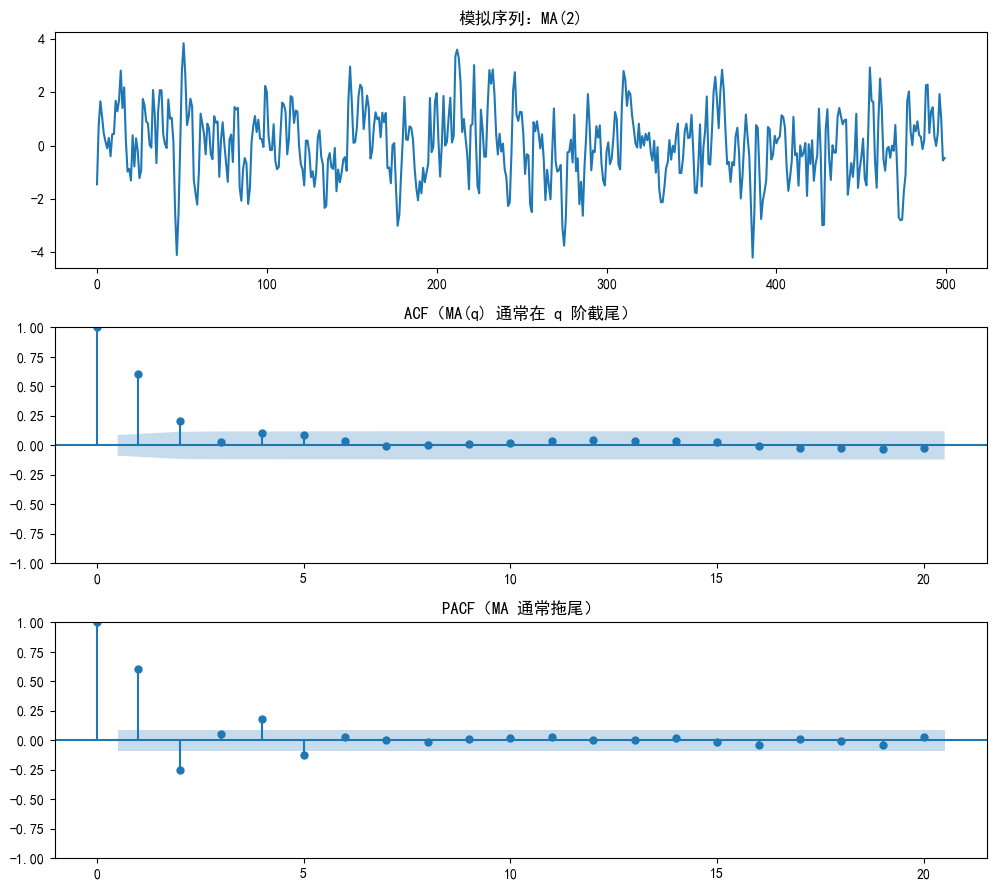

In [7]:
# --- 案例二：MA(2) ---
print("--- 案例二：MA(2) 模型 ---")

# MA(2)：y_t = ε_t + 0.8 ε_{t-1} + 0.4 ε_{t-2}
ar_params = np.array([])
ma_params = np.array([0.8, 0.4])

ma_process = ArmaProcess.from_coeffs(arcoefs=ar_params, macoefs=ma_params)

np.random.seed(200)
ma_data = ma_process.generate_sample(nsample=500)

fig, axes = plt.subplots(3, 1, figsize=(10, 9))
axes[0].plot(ma_data)
axes[0].set_title("模拟序列：MA(2)")

plot_acf(ma_data, ax=axes[1], lags=20, title="ACF（MA(q) 通常在 q 阶截尾）")
plot_pacf(ma_data, ax=axes[2], lags=20, title="PACF（MA 通常拖尾）")

plt.tight_layout()
plt.show()


In [8]:
# MA(2) 等价于 ARIMA(0,0,2)
model_ma = ARIMA(ma_data, order=(0, 0, 2)).fit()
print(model_ma.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -704.426
Date:                Fri, 09 Jan 2026   AIC                           1416.852
Time:                        15:58:25   BIC                           1433.710
Sample:                             0   HQIC                          1423.467
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0582      0.100      0.584      0.559      -0.137       0.253
ma.L1          0.8252      0.041     19.978      0.000       0.744       0.906
ma.L2          0.4180      0.041     10.099      0.0

## 3.5 ARMA(p,q)：惯性 + 冲击的混合

真实世界经常同时存在：
- **惯性（AR）**：例如销量受上个月销量影响；
- **短期冲击（MA）**：例如某次活动/舆情导致短期偏离。

ARMA(p,q) 的经验特征：ACF 与 PACF 往往都会拖尾，因此仅凭图形精确定阶会更难。
常见策略是从低阶（如 (1,1)）开始，结合 AIC/BIC 与残差诊断逐步选择。


--- 案例三：ARMA(1,1) 模型 ---


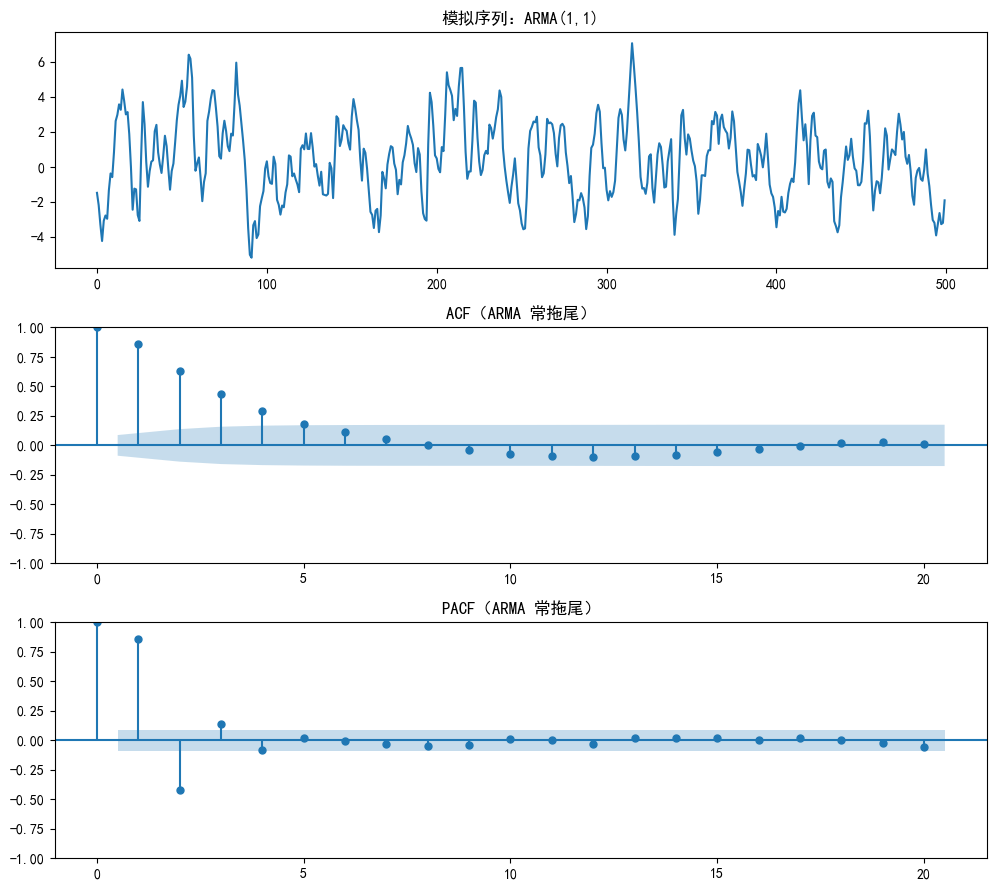

In [9]:
# --- 案例三：ARMA(1,1) ---
print("--- 案例三：ARMA(1,1) 模型 ---")

# ARMA(1,1)：y_t = 0.8 y_{t-1} + ε_t + 0.5 ε_{t-1}
ar_params = np.array([0.8])
ma_params = np.array([0.5])

arma_process = ArmaProcess.from_coeffs(arcoefs=ar_params, macoefs=ma_params)

np.random.seed(300)
arma_data = arma_process.generate_sample(nsample=500)

fig, axes = plt.subplots(3, 1, figsize=(10, 9))
axes[0].plot(arma_data)
axes[0].set_title("模拟序列：ARMA(1,1)")

plot_acf(arma_data, ax=axes[1], lags=20, title="ACF（ARMA 常拖尾）")
plot_pacf(arma_data, ax=axes[2], lags=20, title="PACF（ARMA 常拖尾）")

plt.tight_layout()
plt.show()


In [10]:
# ARMA(1,1) 等价于 ARIMA(1,0,1)
model_arma = ARIMA(arma_data, order=(1, 0, 1)).fit()
print(model_arma.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -709.905
Date:                Fri, 09 Jan 2026   AIC                           1427.810
Time:                        15:58:25   BIC                           1444.669
Sample:                             0   HQIC                          1434.426
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4134      0.284      1.455      0.146      -0.144       0.970
ar.L1          0.7579      0.032     24.059      0.000       0.696       0.820
ma.L1          0.5038      0.043     11.664      0.0

# 总结

## 今日所学
- 趋势导致的非平稳：用 **一阶/二阶差分**（`Series.diff()`）。
- 季节性：用 **季节性差分**（`Series.diff(periods=s)`）。
- 定阶线索：在**平稳序列**上观察 **ACF/PACF** 的截尾与拖尾。

## 与 ARIMA 的关系
ARIMA(p, d, q) 三个参数含义：
- `p`：AR 阶数（常从 PACF 的截尾特征获取线索）
- `d`：差分次数（让序列更接近平稳）
- `q`：MA 阶数（常从 ACF 的截尾特征获取线索）
